In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import shared_encoder, detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

import numpy as np

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [160, 480]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [8]:
import yaml
# with open('/root/Internship-Valeo/Project/configs/superpoint_kitti360.yaml', 'r') as stream:
#     config = yaml.safe_load(stream)
with open('/root/Internship-Valeo/Project/configs/superpoint_kitti.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [9]:
config1 = config
config = dict_update(default_config, config['data'])

In [10]:
default_model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [11]:
model_config = dict_update(default_model_config, config1['model'])

In [12]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
# from datasets import coco
# data = coco.Coco()
# files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# val_gen = data._get_data(files, 'validation', **config)

In [14]:
# from datasets.kitti360 import Kitti
# data = Kitti(config = config)
# files = data._init_dataset(config = config)
# train_gen = data._get_data(files = files, split_name = 'training',config = config)
# val_gen = data._get_data(files = files, split_name = 'validation',config = config)

In [15]:
from datasets.kitti import Kitti
data = Kitti(config = config)
files = data._init_dataset(config = config)
train_gen = data._get_data(files = files, split_name = 'training',config = config)
val_gen = data._get_data(files = files, split_name = 'validation',config = config)

In [17]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss'] * self.loss_fn(descriptors = inputs[0], 
                                                          warped_descriptors = inputs[1],
                            homographies = inputs[2], valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'detector_precision')
        self.add_metric(metrics['recall'], name = 'detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name = name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'warped_detector_precision')
        self.add_metric(metrics['recall'], name = 'warped_detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    inputs = {'image':Input(shape = (None, None, 1), name = 'image'),
              'name': Input(shape = (None,1), name = 'name'),
              'keypoints':Input(shape = (None,None), name = 'keypoints'),              
              'valid_mask':Input(shape = (None,None), name = 'valid_mask'),
              'warped':{
                  'image':Input(shape = (None, None, 1), name = 'warped_image'),
                  'name': Input(shape = (None,1), name = 'warped_name'),
                  'keypoints':Input(shape = (None, None), name = 'warped_keypoints'),
                  'valid_mask':Input(shape = (None, None), name = 'warped_valid_mask'),
                  'homography':Input(shape = (8,), name = 'homography'),
               }}

#     inputs = OrderedDict((('image',Input(shape = (240, 320, 1), name = 'image')),
#               ('name', Input(shape = (), name = 'name')),
#               ('keypoints',Input(shape = (240,320), name = 'keypoints')),              
#               ('valid_mask',Input(shape = (240,320), name = 'valid_mask')),
#               ('warped',OrderedDict((
#                   ('image',Input(shape = (240, 320, 1), name = 'warped_image')),
#                   ('name', Input(shape = (), name = 'warped_name')),
#                   ('keypoints',Input(shape = (240, 320), name = 'warped_keypoints')),
#                   ('valid_mask',Input(shape = (240, 320), name = 'warped_valid_mask')),
#                   ('homography',Input(shape = (8,), name = 'homography')),))
#               )))

#     images_input = Input(shape = (240, 320,1), name = 'image')
#     points_maps_input = Input(shape = (240, 320), name = 'keypoints')
#     homography_list_input = Input(shape = (8,), name = 'homography') 
#     warped_images_input = Input(shape = (240, 320, 1), name = 'warped_image')

#     valid_masks_input = Input(shape = (240, 320), name = 'warped_valid_mask')
#     warped_points_maps_input = Input(shape = (240, 320), name = 'warped_keypoints')
    
    homography_model = HomographyModel()
#     homography = homography_model(homography_list_input)
    homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(shape = (None, None, 1), model_config = model_config)
    encoder_output = encoder(inputs['image'])
    warped_encoder_output = encoder(inputs['warped']['image'])
    
    detector = detector_head(shape= (None, None, 128), model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape= (None, None, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)

#     detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output])
    detector_loss_layer = DetectorLossLayer()([inputs['keypoints'],
                                                 detector_output, inputs['valid_mask']])
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
#                                                 warped_detector_output, 
#                                                       valid_masks_input])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
                                                warped_detector_output, 
                                                      inputs['warped']['valid_mask']])
    
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                                    warped_descriptor_output['descriptors_raw'], 
#                                           homography, valid_masks_input])
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          inputs['warped']['homography'], inputs['warped']['valid_mask']])
    model = keras.models.Model(inputs = inputs,#images_input, homography_list_input, 
#                                          warped_images_input, 
#                                          valid_masks_input, 
#                                          points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [18]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


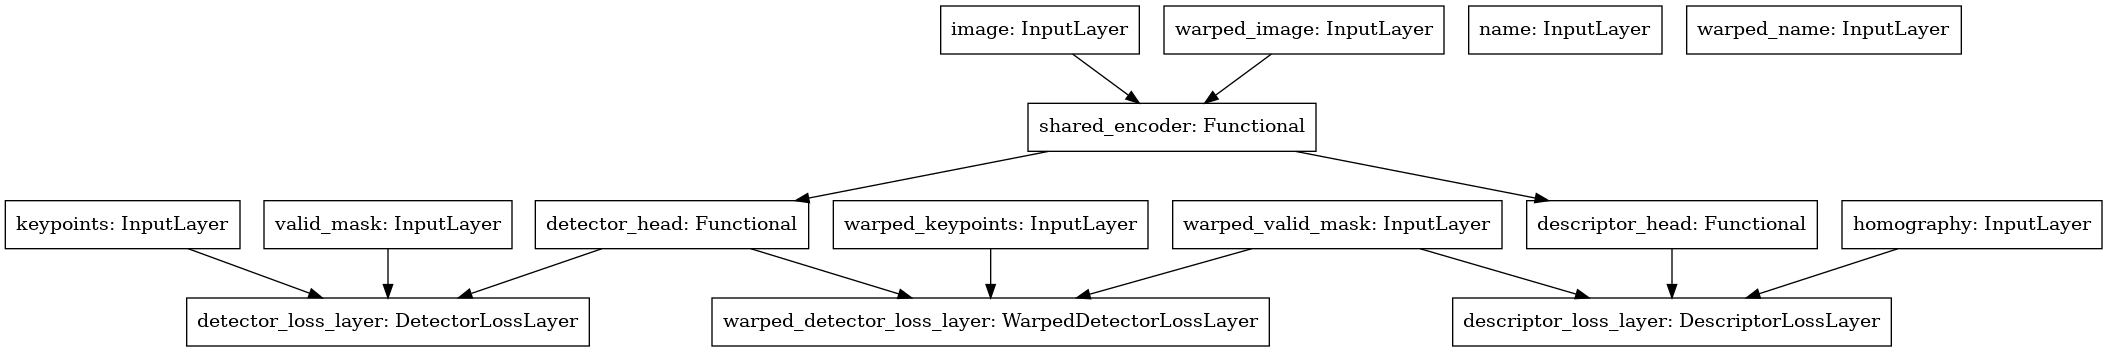

In [19]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [20]:
def detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def warped_detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def descript_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics1(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = [detect_loss, warped_detect_loss, descript_loss],
             loss_weights=[1., 1., 1.])
#                        metrics = [model_metrics, dummy_metrics, dummy_metrics1])

In [21]:
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         # Path where to save the model
#         # The two parameters below mean that we will overwrite
#         # the current checkpoint if and only if
#         # the `val_loss` score has improved.
#         # The saved model name will include the current epoch.
#         filepath="/root/Internship-Valeo/Project/results/superpoint070422_{epoch}",
#         save_best_only=True,  # Only save a model if `val_loss` has improved.
#         monitor="val_loss",
#         verbose=1,)

TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [22]:
# image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
# point_path_train = '/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014'
# # homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'

# # warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
# # warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'


In [23]:
train_image_path = files['image_paths']
train_gen = train_gen.repeat()
train_gen = train_gen.batch(model_config['batch_size'])
val_gen = val_gen.take(config['validation_size'])
val_gen = val_gen.batch(model_config['eval_batch_size'])

In [ ]:
steps_per_epoch = len(train_image_path)//model_config['batch_size']
epochs = config1['train_iter']//steps_per_epoch
history = model.fit(x = train_gen, validation_data = val_gen, batch_size = model_config['batch_size'], 
                     steps_per_epoch = steps_per_epoch, epochs=epochs,
                    callbacks=[TerminateOnNaN, 
                        tensorboard_callback])

Epoch 1/66
3614/9055 [==========>...................] - ETA: 12:00 - loss: 7.7237 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - detector_precision: 9.1537 - detector_recall: 0.9890 - warped_detector_precision: 0.0000e+00 - warped_detector_recall: nan

In [23]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-07042022')
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-kitti360-01092022')
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-kitti360-100723')
model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-depthBasedWarping-kitti-230924')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/checkpoint-superpoint-kitti360-100723/assets


In [22]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-07042022')
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-kitti360-01092022')
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-kitti360-100723')

# Converting models to ONNX format

In [23]:
from tensorflow.keras.models import Model

In [24]:
model.get_layer('descriptor_loss_layer').input

[<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'homography')>,
 <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'warped_valid_mask')>]

In [25]:
model.get_layer('detector_loss_layer').input

[<KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'keypoints')>,
 {'logits': <KerasTensor: shape=(None, None, None, 65) dtype=float32 (created by layer 'detector_head')>,
  'prob': <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'detector_head')>},
 <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'valid_mask')>]

In [26]:
# desc = model.get_layer('descriptor_loss_layer').input[0]
# desc = tf.image.resize(desc, model_config['grid_size'] * tf.shape(desc)[1:3], method='bilinear')
# desc = tf.nn.l2_normalize(desc, -1)

In [26]:
SPModel = Model(inputs=model.input['image'],
                         outputs=[model.get_layer('descriptor_loss_layer').input[0],
                                 model.get_layer('detector_loss_layer').input[1]['logits'],
                                  model.get_layer('detector_loss_layer').input[1]['prob']])

In [27]:
SPModel.save('/root/Internship-Valeo/Project/results/model_saved_onnx/inference-model-superpoint-kitti360-100723')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/model_saved_onnx/inference-model-superpoint-kitti360-100723/assets


In [21]:
x = iter(train_gen).get_next()

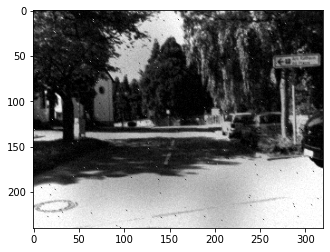

In [23]:
plt.imshow(x['image'], cmap = 'gray')

In [32]:
x['name'][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'0040000005884'>

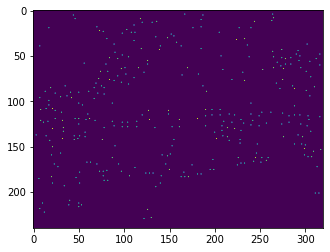

In [33]:
plt.imshow(x['keypoints'][0])

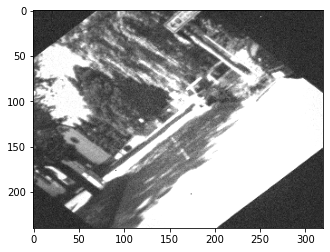

In [34]:
plt.imshow(x['warped']['image'][0], cmap = 'gray')

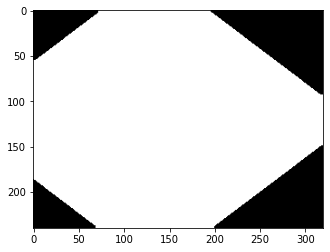

In [35]:
plt.imshow(x['warped']['valid_mask'][0], cmap = 'gray')

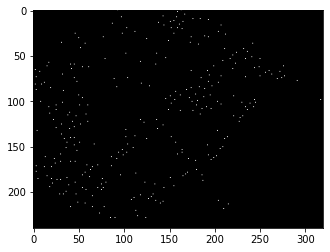

In [36]:
plt.imshow(x['warped']['keypoints'][0], cmap ='gray')

In [37]:
x['warped']['homography'][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 7.1616518e-01, -9.4435894e-01,  1.7789217e+02,  5.3668100e-01,
        7.0883399e-01, -3.7880981e+01,  1.2788493e-05,  1.9257735e-09],
      dtype=float32)>

In [38]:
x['warped']['name']

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'0040000005884'], dtype=object)>

In [39]:
model.predict(x)

[0.8193333148956299, 0.9472948312759399, 0.9994349479675293]